In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
cd 'drive/My Drive/Development/Biometrics/face'

[Errno 2] No such file or directory: 'drive/My Drive/Development/Biometrics/face'
/content/drive/My Drive/Development/Biometrics/face


# Biometrics System Concepts
# Assignment 3: Face Recognition
In this assignment, you will test/implement and report about a face recognition algorithm based on Principal Components Analysis (Eigenfaces), Linear Discriminant Analysis (Fisherfaces), Local Binary Pattern (LBP) and deep learning. The first three procedures are representative of old-school computer vision techniques that are still in use and retain their merits. All four generated feature vector descriptors that can be compared for verification/identification.

The structure of this document follows a typical face recognition pipeline and consists of the following major sections: 
1. Loading Image Data
2. Detecting faces in the images
3. Extracting features
4. Classification in typical biometrics setting
5. Advanced classification systems
6. Evaluation
7. Task


**Note: large parts of this notebook are based on the [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock.**

## Importing and installing packages
Note: this exercise makes use of keras, which is now part of TensorFlow 2.0. It is easy to install using pip, have a look at the [installation guide](https://www.tensorflow.org/install) for more information. Note that you need Python Version 3.5 to 3.7 for this to run (not lower, not higher).

In [8]:
import sys
print("Python version :", sys.version)

import numpy as np
import cv2
from pathlib import Path

import pickle # exporting intermediate data to disk

from tqdm.notebook import tqdm as tqdm_notebook # Visual progress bar

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline

# The following package contains some handy routines for image manipulation
# they have been developed by Adrian Rosenbrock
# Simply install this package in your environment using "conda install imutils"
# See https://www.pyimagesearch.com/opencv-tutorials-resources-guides/ for further info
import imutils

Python version : 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


## 1. Loading an image datasets

[From OpenCV Docs](https://docs.opencv.org/3.4/da/d60/tutorial_face_main.html):

In order to test face recognition systems, we need databases of labeled face images. You can either create your own dataset (but that takes time) or, better, start with one of the available face databases, http://face-rec.org/databases/ gives you an up-to-date overview. Some interesting databases are:

* [AT&T Facedatabase](http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html). Quoted from http://face-rec.org):
> The AT&T Facedatabase, sometimes also referred to as ORL (Olivetti Research Lab) Database of Faces or Olivetti faces, contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).The AT&T Facedatabase is good for initial tests, but it's a fairly easy database. The Eigenfaces method already has a 97% recognition rate on it, so you won't see any great improvements with other algorithms.

This database can be accessed in a straightforward way through the [sklearn.datasets.fetch_olivetti_faces](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces) module. 
A preview of this database can be seen [here](https://www.cl.cam.ac.uk/research/dtg/attarchive/facesataglance.html) 

* [The CALTECH Faces dataset](http://www.vision.caltech.edu/html-files/archive.html) is a popular benchmark dataset for face recognition algorithms. Overall, the dataset consists of 450 images of approximately 27 unique people. Each subject was captured under various lighting conditions, background scenes, and facial expressions. Furthermore, bounding box coordinates are provided to crop the faces prior to recognition. A routine (load_caltech_faces)is provided to read the data. 

* [The Labeled Faces in the Wild (lfw)](http://vis-www.cs.umass.edu/lfw/). This dataset is a collection of more than 13000 JPEG pictures of famous people collected over the internet. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. These images are completely unconstrained (pose, illumination, expression, occlusion).  The only constraint on these faces is that they were detected by the Viola-Jones face detector. Each picture is centered on a single face. A loader [sklearn.datasets.fetch_lfw_people](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people) is provided by scikit-learn. 


### 1.1 Read caltech dataset
For this assignemnt we'll work with the CALTECH dataset because it contains raw images and is not very large. 

The data are returned as a list object with the following components:
* data: (NxM) matrix of N flattened (linear dimension M) images
* images: (Nx(nxm)) matrix of N images of dimension nxm 
* target: N-dimensional vector of labels 

In [0]:
# Size of each face after preprocessing
face_size=(47, 47)

In [10]:
import pandas as pd

def read_img(imagePath):
    # Load the image and convert it to grayscale
    gray = cv2.imread(str(imagePath), cv2.IMREAD_GRAYSCALE)
    # ROI (region of interest), and resize it to a canonical size
    imagePathStem = str(imagePath.stem)
    k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1
    return gray, imagePath.parent.name
     
# Grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("CalTechFacesDirs")
imagePaths = list(datasetPath.glob("*/*.jpg"))

# Read image and label information
imgs = [read_img(imagePath) for imagePath in tqdm_notebook(imagePaths)]
data = pd.DataFrame(imgs, columns =['images', 'target']).to_dict('list')

# Check if all images were found successfully (5 images were removed from the original set)
assert len(data['images']) == len(data['target']) == 445

### 2.2. Inspect some images

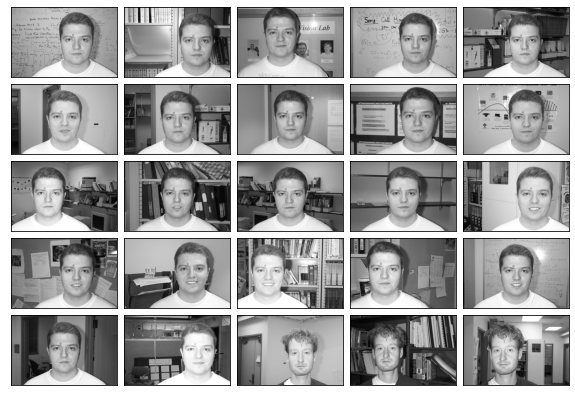

In [11]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 5), 
                 axes_pad=0.1,
                 )

for ax, im, label in zip(grid, data['images'], data['target']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## 2. Detecting faces


Even though the bounding box coordinates are stored in the <em>CalTechFacesDirs/ImageData.mat</em> file, we'll be computing them from scratch for demonstrative purposes. 

### 2.1. Detect faces
There are many different face detection algorithms, you can follow the [Learn OpenCV tutorial on Face Detection](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/) for some (very coarse) background info for two "conventional" (HAAR-cascade, HOG) CV methods and two Deep Neural Net (Dlib) based (SSD, MMOD) methods. Please study the relevant publications on these detectors to understand their functioning.

* Some background on Haar, HOG and MMOD face detectors can be found in this [Guide to Face Detection in Python](https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1). 

* For MMOD specifically, see: [Max-Margin Object Detection by Davis E. King](http://arxiv.org/abs/1502.00046) and the comments at the beginning of the [dnn_mmod_ex.cpp code](https://github.com/davisking/dlib/blob/master/examples/dnn_mmod_ex.cpp).

* For further info on the Single-Shot-Multibox Detector, see [the arXiv publication](https://arxiv.org/abs/1512.02325).

In this assignment we'll be using HAAR, you can find more information about this technique on the [OpenCV website](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html).

In [0]:
faceCascade = cv2.CascadeClassifier('./models/haarcascade_frontalface_default.xml')

In [13]:
from sklearn.datasets.base import Bunch
from sklearn.preprocessing import LabelEncoder

feat_data, images, labels = [], [], []

for img, label in zip(data['images'], data['target']):
    faces = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )
    # Iterate faces found in image
    for (x, y, w, h) in faces:
        new_img = img.copy()
        # Extract ROI
        raw_face = new_img[y:y+h, x:x+w]
        # Resize the face to the preferred size
        face = cv2.resize(raw_face, face_size)
        face_flatten = face.flatten()
        images.append(np.expand_dims(face, axis=-1)), feat_data.append(face_flatten), labels.append(label)

# Encode classes as integer value
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(labels)

faces = Bunch(data       = np.array(feat_data), 
              images     = np.array(images), 
              labels     = np.array(labels),
              target     = np.array(targets))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


### 2.2. Print statistics of data

In [14]:
# Extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces.images.shape
imshape = (h, w, n_channels)

# Count number of individuals
n_classes = faces.target.max() +1
n_features = faces.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

Total dataset size:
n_samples: 440
n_classes: 26
n_features: 2209


### 2.3. Visualise some faces

*It looks like the detection process is a little ... too good since sometimes multiple faces get extracted and one ends up with mislabeled faces. A solution to this problem would be to use the .mat file, because one can hardly tell the algorithm that detects faces not to detect some of them.*

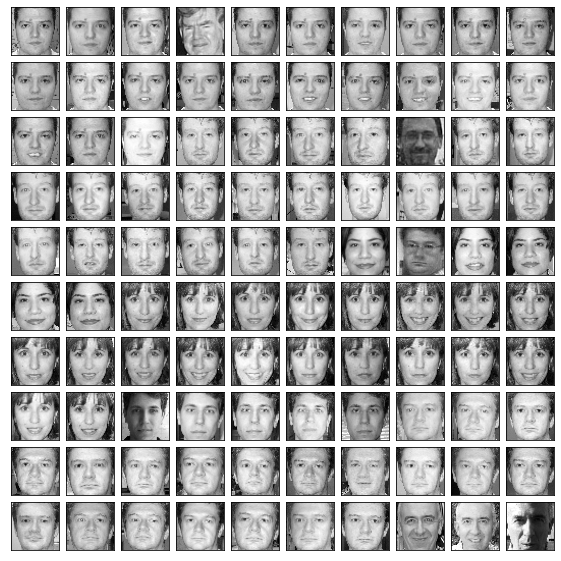

In [15]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10), 
                 axes_pad=0.1,
                 )

for ax, im, t in zip(grid, faces['images'], faces['target']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

*The class distribution may be interesting to visualise too, as any class imbalance should be accounted.*

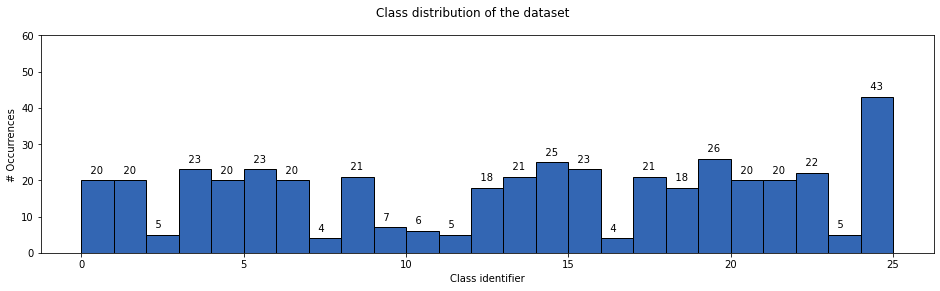

In [16]:
 figure, axes = plt.subplots(figsize=(16,4))
 figure.suptitle('Class distribution of the dataset') 
 nb_bins = max(faces.target)
 histogram = axes.hist(faces.target, color=(0.2,0.4,0.7), edgecolor='black', histtype='bar', bins=nb_bins)
 for i in range(nb_bins):
    plt.text(histogram[1][i], histogram[0][i]+2, "   " + str(int(histogram[0][i])))
 axes.set(xlabel='Class identifier')  
 axes.set(ylabel='# Occurrences')  
 axes.set(ylim=[0.0,60.0])
 plt.show()

## 3. Feature Extraction

Images tend to be large and can differ a lot in lighting, positioning, ... To combat this we'll extract features from each image using 4 different techniques. They all belong to the global/holistic feature representation approaches that map the image to a lower-dimensional subspace through linear and non-linear mapping. 

In [0]:
from abc import ABC, abstractmethod 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

"""
A class of strategies for recognizing faces in images.
The constructor takes a dataset split in a training and test set.
Every strategy can be fitted, can be used to generate embeddings, distances
  between embeddings.
The methods returning scores can be used for validation / evaluation.
"""
class FaceRecognitionStrategy(ABC): 
  def __init__(self, x_train, y_train, x_test, y_test, name=""):
    self.name = name
    self.x_train = x_train
    self.y_train = y_train
    self.x_test = x_test
    self.y_test = y_test
  def fit(self): # train model on data (possibly supervised)
    pass
  def describe(self, images): # calculate vector embeddings for images
    pass
  def distance(self, embedding_1, embedding_2): # calculate distance between two embeddings
    pass
  def accuracy(self):
    knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    embeddings = self.describe(self.x_train)
    embeddings_test = self.describe(self.x_test)
    knn.fit(embeddings, self.y_train)
    return accuracy_score(self.y_test, knn.predict(embeddings_test))
  def get_scores(self):
    embeddings = strategy.describe(self.x_train) # vector embeddings for train set
    size = len(embeddings)
    distances = np.array([self.distance(embeddings[i], embeddings[j]) for i in range(size) for j in range(size) if i < j])
    genuine_id = np.array([1 if y_train[i] == y_train[j] else 0 for i in range(size) for j in range(size) if i < j])
    min_distance = min(distances)
    distances_normalised = ((distances - min_distance) / (max(distances) - min_distance))
    matrix = np.zeros((size,size))
    matrix[np.triu_indices(size, k=1)] = distances_normalised
    matrix = 1 - (matrix + matrix.T)
    return genuine_id, distances, distances_normalised, matrix
  def get_scores_test(self):
    embeddings = strategy.describe(self.x_train) # vector embeddings for train set
    embeddings_test = strategy.describe(self.x_test)
    distances_test = np.array([self.distance(embeddings_test[i], embeddings[j]) 
      for i in range(len(embeddings_test)) 
      for j in range(len(embeddings))])
    genuine_id_test = np.array([1 if y_test[i] == y_train[j] else 0 
      for i in range(len(embeddings_test)) 
      for j in range(len(embeddings))])
    min_distance = min(distances_test)
    distances_normalised_test = ((distances_test - min_distance) / (max(distances_test) - min_distance))
    matrix_test = 1 - np.reshape(distances_normalised_test, (len(embeddings_test), len(embeddings))) # similarity of probes versus gallery
    return genuine_id_test, distances_test, distances_normalised_test, matrix_test
  def tune(self):
    pass

class DimensionalityReduction(FaceRecognitionStrategy):
  def __init__(self, x_train, y_train, x_test, y_test, name, nb_components=25):
    super().__init__(x_train, y_train, x_test, y_test, name)
    self.nb_components = min(nb_components, min(len(self.x_train), len(self.x_train[0].flatten())))

### 3.3. LBP for face recognition

Local Binary Patterns, or LBPs for short, are a texture descriptor made popular by the work of Ojala et al. in their 2002 paper, [Multiresolution Grayscale and Rotation Invariant Texture Classification with Local Binary Patterns](http://www.outex.oulu.fi/publications/pami_02_opm.pdf) (although the concept of LBPs were introduced as early as 1993).

Unlike [Haralick texture features](http://haralick.org/journals/TexturalFeatures.pdf) that compute a global representation of texture based on the [Gray Level Co-occurrence Matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix), LBPs instead compute a local representation of texture. This local representation is constructed by comparing each pixel with its surrounding neighborhood of pixels. See [PyImageSearch](https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/) and [Scikit-Image](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html) for further details on LBP.
<!--![LBP](notebook_images/LBP.png)-->

In [0]:
from localmodules.local_binary_patterns import LBP
#from scipy.stats import chisquare

class LBPStrategy(FaceRecognitionStrategy):
  def __init__(self, x_train, y_train, x_test, y_test):
    super().__init__(x_train, y_train, x_test, y_test, "LBP")
  def fit(self):
    self.descriptor = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
  def describe(self, images):
    return self.descriptor.describe_list(images[...,0])
  def distance(self, embedding_1, embedding_2):
    return cv2.compareHist(np.float32(embedding_1), np.float32(embedding_2), cv2.HISTCMP_CHISQR)

### 3.1. Eigenfaces for face recognition

In 1971 Goldstein et al. ([Identification of human faces](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=1450184&url=http%3A%2F%2Fieeexplore.ieee.org%2Fxpls%2Fabs_all.jsp%3Farnumber%3D1450184)) demonstrated that facial characteristics can be manually extracted, quantified and used for face recognition. The question then remained: could this be done in an automatic fashion? 

It wasn’t until the 1987 paper by Kirby and Sirovich ([A Low-Dimensional Procedure for the Characterization of Human Faces](https://gurus.pyimagesearch.com/wp-content/uploads/2015/10/kirby_1987.pdf)) that we were able to answer this question. This paper is considered to be a seminal work in the history of computer vision — and while other approaches have since been proposed that can outperform Eigenfaces, it’s still important that we take the time to understand and appreciate this algorithm. [Turk and Pentland](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjmvqy6jqfhAhWFZFAKHb74DNgQFjAAegQIABAC&url=http%3A%2F%2Fwww.face-rec.org%2Falgorithms%2Fpca%2Fjcn.pdf&usg=AOvVaw2IlxVps8dldmeA01yQDa_I) built on this idea in the context of face recognition. 

The Eigenfaces algorithm uses Principal Component Analysis to construct a low-dimensional representation of face images.

<!--![An example of applying an eigenvalue decomposition to a dataset of faces and extracting the 16 "eigenfaces" with the largest corresponding eigenvalue magnitude.](notebook_images/what_is_fr_eigenfaces.jpg)-->


This involves collecting a dataset of faces with multiple face images per person we want to identify — like having multiple training examples of an image class we would want to label in image classification. Given this dataset of face images (presumed to be the same width, height, and ideally — with their eyes and facial structures aligned at the same (x, y)-coordinates, we apply an eigenvalue decomposition of the dataset, keeping the eigenvectors with the largest corresponding eigenvalues.

Given these eigenvectors, a face can then be represented as a linear combination of what Kirby and Sirovich call eigenfaces.

Face identification can be performed by computing the Euclidean distance between the eigenface representations and treating the face identification as a k-Nearest Neighbor classification problem — however, we tend to commonly apply more advanced machine learning algorithms to the eigenface representations.

Last, it’s important to note that the Eigenfaces algorithm is **not-specific to faces** — we can actually apply it to any arbitrary dataset containing objects of the same type that need to be compared, whether that may be bicycles, cans of soup, or ancient Aztec coins. The Eigenfaces algorithm can be modified to accommodate each of these identification tasks.

In [0]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

class PCAStrategy(DimensionalityReduction):
  def __init__(self, x_train, y_train, x_test, y_test):
    super().__init__(x_train, y_train, x_test, y_test, "PCA")
  def fit(self):
    data = np.array([image.flatten() for image in self.x_train])
    self.descriptor = PCA(n_components=self.nb_components, svd_solver='full', whiten=True).fit(data) # randomized SVD not reproducable
  def describe(self, images):
    image_features = np.array([image.flatten() for image in images]) # just the images, flattened
    return self.descriptor.transform(image_features)
  def distance(self, embedding_1, embedding_2):
    return euclidean(embedding_1, embedding_2)

### 3.2. Fisherfaces for face recognition

From [Scholarpaedia](http://www.scholarpedia.org/article/Fisherfaces):
> When the goal is classification rather than representation, PCA may not yield the most desirable results. In such cases, one wishes to find a subspace that maps the sample vectors of the same class in a single spot of the feature representation and those of different classes as far apart from each other as possible. The techniques derived to achieve this goal are known as discriminant analysis (DA).
The most known DA is [Linear Discriminant Analysis (LDA)](http://www.scholarpedia.org/article/Linear_Discriminant_Analysis), which can be derived from an idea suggested by R.A. Fisher in 1936. When LDA is used to find the subspace representation of a set of face images, the resulting basis vectors defining that space are known as [Fisherfaces](http://www.scholarpedia.org/article/Fisherfaces).

<!--![Example of FisherFaces](notebook_images/FisherFaces.jpg)-->

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import euclidean

class LDAStrategy(DimensionalityReduction):
  def __init__(self, x_train, y_train, x_test, y_test):
    super().__init__(x_train, y_train, x_test, y_test, "LDA")
  def fit(self):
    train_set = np.array([image.flatten() for image in self.x_train])
    self.descriptor = LinearDiscriminantAnalysis(n_components=self.nb_components).fit(train_set, self.y_train)
  def describe(self, images):
    image_set = np.array([image.flatten() for image in images])
    return self.descriptor.transform(image_set)
  def distance(self, embedding_1, embedding_2):
    return euclidean(embedding_1, embedding_2)

### 3.4. Deep metric learning
Similar to previous techniques, we can use deep learning to generate an enriched representation of faces that you can use in simple or more complicated classification algorithms. 
Instead of building networks that are trained end-to-end to perform face recognition, we will use deep metric learning. Metric learning based methods learn a projection of the input data on a low-dimensional vector, such that classification in that lower-dimensional space is much easier and can be performed using simple distance metrics. 

In the context of face recognition we can observe the following major Deep Learning based approaches since 2014.

1. The first approach was developed and presented in 2014 by researchers at Facebook and is called [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) . The major contributions where a CDNN to classify faces. In addition a 3D/2D alignment procedure is applied prior to classification. 
The CDNN is trained as a classifier on the SFC (Social Face Classification) dataset, which is a very large (4.4 million image of 4000 individuals) dataset. This setting is called supervised.  The challenge is whether this can also be generalizd to other datasets and subjects as well. By training it on the large collection of uncontrolled images, an embedded representation (the vector description prior to the classification layer) can be generated that is, allegedly, generalizable to other face recognition data. One can then use this representation as we have previously done for classical representations. 
By way of demonstration they tested it on the LFW dataset to achieve >95% verification accuracy. <br> 


2. The second approach was developed by researchers at Google.  An in-depth presentation of their FaceNet/OpenFace deep CNN's for metric embedding of faces is given by [Martin Krasser et al](http://krasserm.github.io/2018/02/07/deep-face-recognition/). Note that this method was trained on 200 million images of eight million identities. The main methodological point is that these networks are trained using a special loss-function: the triplet loss function. 
>This function is minimized when the distance between an anchor image $x_{ai}$ and a positive image $x_{pi}$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x_{ni}$ (different identity) by at least a margin $\alpha$. Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. 

There is a very elegant Python implementations available of the FaceNet/OpenFace approach. It is nicely described in [this PyImageSearch tutorial](https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/). It explicitly includes the Dlib package with the [face_recognition modules](https://face-recognition.readthedocs.io/en/latest/index.html) for face detection and recognition. Especially the latter package provides a very convenient interface. 

From the [Dlib face_recognition.py](https://github.com/davisking/dlib/blob/master/python_examples/face_recognition.py) code, we get an application view of the embedding:

> This example shows how to use dlib's face recognition tool.  This tool maps an image of a human face to a 128 dimensional vector space where images of the same person are near to each other and images from different people are far apart.  Therefore, you can perform face recognition by mapping faces to the 128D space and then checking if their Euclidean distance is small enough. 

> When using a distance threshold of 0.6, the dlib model obtains an accuracy of 99.38% on the standard LFW face recognition benchmark, which is comparable to other state-of-the-art methods for face recognition as of February 2017. This accuracy means that, when presented with a pair of face images, the tool will correctly identify if the pair belongs to the same person or is from different people 99.38% of the time.



#### 3.4.1 Deep Metric Learning using Siamese Networks

In the [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) paper they also tested a [siamese network](https://en.wikipedia.org/wiki/Siamese_network) DNN architecture for generating embedded vector representations.  This consists of two copies of the same CNN (sharing their weights) that are applied to pairs of images. During training the distance between the embedded representations of the same individual is minimized, and the distances between embedded representations of different individuals is maximized. In the mean time, this work was extended, steadily increasing the performance. Siamese networks are an example of *One-shot Learning* where you tyically have very few samples per object or dynamically changing number of objects/subjects. While [this link](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) tests it on a non-face recognition task, it can be applied to face recognition as well.

The localmodules.siamese file contains the description of a shallow CNN model that is trained with [contrastive loss](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
This subnetwork is copied twice and the output of both siamese copies are then passed onto a vector euclidean distance (ED) calculation layer. The network gets as input pairs of imposter or genuine images with the associated label (genuine = 0, imposter = 1). You can make use of the output of the network or the output before the ED layer (embedded) in your validation.

Note: this part on Siamese networks is adapted from (from [Packt tutorial](https://hub.packtpub.com/face-recognition-using-siamese-networks-tutorial/), which seems to be a re-implementation from  [this Packt book on Neural Network Projects with Python](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789138900)). See also [this Hackernoon tutorial](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e).

Note: you can change the CNN at your will, but beware that it might take additional training time.

Depending on the complexity of the Siamese network the training might take a while. You can also change the number of epochs to improve the training (with the risk of overfitting). You will notice that a small number (<10) of epochs already gets you a decent performance.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          894400      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

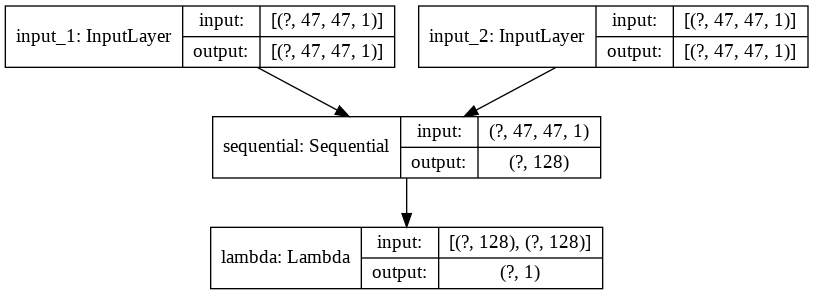

In [21]:
import localmodules.siamese as siamese
from tensorflow.keras.utils import plot_model
encoder, model = siamese.create_siamese_model(imshape)
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [0]:
from tensorflow.keras.optimizers import RMSprop, Adam
from scipy.spatial.distance import euclidean
import localmodules.siamese as siamese
from sklearn.metrics import accuracy_score

class SiameseNetworkStrategy(FaceRecognitionStrategy):
  def __init__(self, x_train, y_train, x_test, y_test):
    super().__init__(x_train, y_train, x_test, y_test, "(D)NN")
    self.encoder, self.model = siamese.create_siamese_model(imshape)
  def fit(self, rms=Adam(), epochs=10):
    x_train_pairs, y_train_pairs = siamese.get_siamese_paired_data(self.x_train, self.y_train)
    self.model.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy])
    self.model.fit([x_train_pairs[:, 0], x_train_pairs[:, 1]], y_train_pairs, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
  def describe(self, images):
    return self.encoder(images.astype(float)).numpy()
  def distance(self, embedding_1, embedding_2):
    return cv2.compareHist(np.float32(embedding_1), np.float32(embedding_2), cv2.HISTCMP_CHISQR)
  def accuracy(self):
    x_test_pairs, y_test_pairs = siamese.get_siamese_paired_data(self.x_test, self.y_test)
    test_scores = self.model.predict([x_test_pairs[:, 0], x_test_pairs[:, 1]])
    return accuracy_score(y_test_pairs, test_scores > 0.5)

One can opt for any of the 4 strategies next. First the model is fitted on the training data, then the accuracy is measured (on the test set). The accuracy is determined with KNN except for the siamese neural network.

In [23]:
# Split train/test data
x_train, x_test, y_train, y_test = train_test_split(faces.images, 
                                                    faces.target, 
                                                    test_size=.25, 
                                                    shuffle=True, 
                                                    stratify=faces.target, 
                                                    random_state=22) # for reproducibility

# Train model and calculate accuracy
strategy = PCAStrategy(x_train, y_train, x_test, y_test)
strategy.fit()
print("Accuracy on the test set: {}".format(strategy.accuracy()))

Accuracy on the test set: 0.8545454545454545


## 4. Classification in typical biometrics setting

In [0]:
strategy_classes = [LBPStrategy, PCAStrategy, LDAStrategy, SiameseNetworkStrategy]
strategies = [strategy(x_train, y_train, x_test, y_test) for strategy in strategy_classes]

#### Task 1: Compute pair-wise matching scores


*I consider all strategies here and determine similarity scores for pairs of samples taken from the training set. The resulting distances, normalised distances and similarity matrices are stored on disk.*

In [25]:
import os.path

"""
This block of code finds scores i.e. distances & similarity matrices for the
train and the test set then stores them on disk.
  The training set result is used for validation.
  The test set scores are used for evaluation.
"""
recompute = False # set to true if starting from scratch
scores_dict = {} # holds the distances & similarity matrices for training set
scores_test_dict = {} # holds the distances & similarities for the test set for the evaluation at the end
for strategy in strategies:
  scores_file = './scores/scores_' + strategy.name + '.p'
  scores_test_file = './scores/scores_test_' + strategy.name + '.p'
  has_scores = os.path.isfile(scores_file)
  has_test_scores = os.path.isfile(scores_test_file)
  if recompute or not(has_scores) or not(has_test_scores): # check if the scores have to be recomputed
    strategy.fit() # if yes the model has to be fitted first
  if recompute or not(has_scores): # recompute training set scores
    (genuine_id, distances, normalised, matrix) = strategy.get_scores()
    pickle_file = open(scores_file, "wb")
    pickle.dump((genuine_id, distances, normalised, matrix), pickle_file)
  else: # load training set scores from disk
    pickle_file = open(scores_file, "rb")
    (genuine_id, distances, normalised, matrix) = pickle.load(pickle_file)
  if recompute or not(has_test_scores): # recompute test set scores
    (genuine_id_test, distances_test, normalised_test, matrix_test) = strategy.get_scores_test()
    pickle_file_test = open(scores_test_file, "wb")
    pickle.dump((genuine_id_test, distances_test, normalised_test, matrix_test), pickle_file_test)
  else: # load test set score from disk
    pickle_file_test = open(scores_test_file, "rb")
    (genuine_id_test, distances_test, normalised_test, matrix_test) = pickle.load(pickle_file_test)
  scores_dict[strategy.name] = (genuine_id, distances, normalised, matrix)
  scores_test_dict[strategy.name] = (genuine_id_test, distances_test, normalised_test, matrix_test)
  print('Number of scores ('+ strategy.name + ') = ', distances.shape[0])
  print('Number of test scores ('+ strategy.name + ') = ', distances_test.shape[0])

Number of scores (LBP) =  54285
Number of test scores (LBP) =  36300
Number of scores (PCA) =  54285
Number of test scores (PCA) =  36300
Number of scores (LDA) =  54285
Number of test scores (LDA) =  36300
Epoch 1/10
50/50 - 2s - loss: 0.0785 - accuracy: 0.7788 - val_loss: 0.0411 - val_accuracy: 0.8678
Epoch 2/10
50/50 - 1s - loss: 0.0240 - accuracy: 0.9744 - val_loss: 0.0309 - val_accuracy: 0.9279
Epoch 3/10
50/50 - 1s - loss: 0.0130 - accuracy: 0.9881 - val_loss: 0.0137 - val_accuracy: 0.9639
Epoch 4/10
50/50 - 1s - loss: 0.0080 - accuracy: 0.9981 - val_loss: 0.0109 - val_accuracy: 0.9784
Epoch 5/10
50/50 - 1s - loss: 0.0055 - accuracy: 0.9994 - val_loss: 0.0087 - val_accuracy: 0.9760
Epoch 6/10
50/50 - 1s - loss: 0.0040 - accuracy: 0.9987 - val_loss: 0.0081 - val_accuracy: 0.9832
Epoch 7/10
50/50 - 1s - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0066 - val_accuracy: 0.9832
Epoch 8/10
50/50 - 1s - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.0050 - val_accuracy: 0.9832
Epoch 9/1

## 5. Advanced Classification Scenario
Biometrics classification is based on generating pairwise matching scores. 
* In verification mode one compares this matching score to a decision threshold in a 1-to-1 classification setting.
* In identifcation mode one uses this matching score to rank the templates in the database and, possibly, thresholding it as well in a 1-to-N classification setting

Hence, a simple pairwise comparision (L2-distance, e.g.) can be used. 

In a more general classification scenario one can use the feature representations to build more complex classifiers (SVM, NN, etc.). Testing then requires a splitting in training and validation subsets. 

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# The strategy used will be overriden by local variables but this code is only for demonstrative purposes anyways
x_train_class, x_test_class, y_train_class, y_test_class = train_test_split(strategy.describe(faces.images), 
                                                       faces.target, 
                                                       test_size=.25, 
                                                       shuffle=True, 
                                                       stratify=faces.target, 
                                                       random_state=22) # for reproducibility

# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier(n_neighbors=2, metric='euclidean')
knn.fit(x_train_class, y_train_class)
acc_knn = accuracy_score(y_test_class, knn.predict(x_test_class))
print(f'KNN accuracy = {acc_knn}')

# SVM
from sklearn.svm import SVC
svm = SVC(C=10.0, gamma=0.0001)
svm.fit(x_train_class, y_train_class)
acc_svm = accuracy_score(y_test_class, svm.predict(x_test_class))
print(f'SVM accuracy = {acc_svm}')

KNN accuracy = 0.9545454545454546
SVM accuracy = 0.9545454545454546


## 6. Evaluation

### 6.1. Validation as verification system

#### Task 2: Compute F1 and accuracy scores for variable (and optimal) thresholds

* Calculate and plot F1 and accuracy scores for a range (min, max) of thresholds.
* Determine some optimal threshold (look up in classification literature)

Max F1 score at threshold = 0.888889 (LBP).
Accuracy at this threshold = 0.942599.
FPR at this threshold = 0.034890.
FRR at this threshold = 0.561154.
Max F1 score at threshold = 0.767677 (PCA).
Accuracy at this threshold = 0.964502.
FPR at this threshold = 0.015222.
FRR at this threshold = 0.489233.
Max F1 score at threshold = 0.747475 (LDA).
Accuracy at this threshold = 0.995100.
FPR at this threshold = 0.001809.
FRR at this threshold = 0.074074.
Max F1 score at threshold = 0.999932 ((D)NN).
Accuracy at this threshold = 0.990347.
FPR at this threshold = 0.006043.
FRR at this threshold = 0.090439.


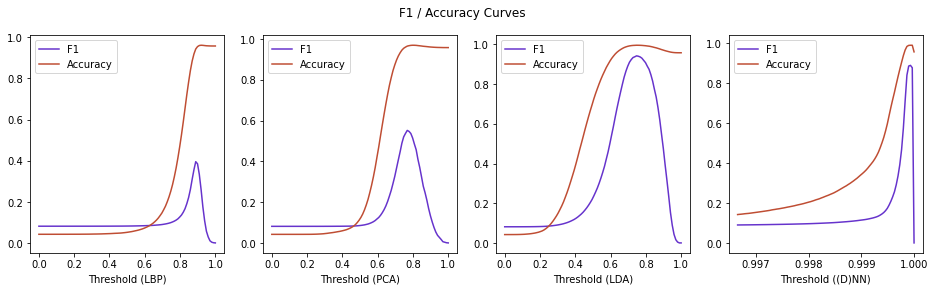

In [27]:
from sklearn.metrics import f1_score, accuracy_score

figure, axes = plt.subplots(ncols=len(strategies), figsize=(16,4))
figure.suptitle('F1 / Accuracy Curves')

i = 0
for strategy in strategies:
  (genuine_id, distances, normalised, _) = scores_dict[strategy.name]
  # variable thresholds
  #max_t = sorted(distances)[len(distances)//10*9]
  #thresholds = np.linspace(0.0, max_t, 100).tolist()
  #thresholds = [0,1,2,3,4,20,30,40,50,60,70,80,90,100,120,140,160,180,200,240,280,320,360,400,500,600,700,800,900,1000]
  #f1_scores = [f1_score(genuine_id, np.where(distances <= t, 1, 0)) for t in thresholds]
  #accuracy_scores = [accuracy_score(genuine_id, np.where(distances <= t, 1, 0)) for t in thresholds]
  scores = 1 - normalised
  min_t = 0.0 if strategy.name != "(D)NN" else sorted(scores)[len(scores)-len(scores)//10*9] # outliers ...
  thresholds = np.linspace(min_t, 1.0, 100).tolist()
  f1_scores = [f1_score(genuine_id, np.where(scores >= t, 1, 0)) for t in thresholds]
  accuracy_scores = [accuracy_score(genuine_id, np.where(scores >= t, 1, 0)) for t in thresholds]
  # visualise
  axes[i].plot(thresholds, f1_scores, color=(0.4,0.2,0.8), label='F1')
  axes[i].plot(thresholds, accuracy_scores, color=(0.75,0.3,0.2), label='Accuracy')
  axes[i].set(xlabel='Threshold (' + strategy.name + ')')
  axes[i].legend()
  i = i + 1
  # maximum F1
  imposters = scores[genuine_id < 1]
  genuine = scores[genuine_id > 0]
  max_f1_t = thresholds[f1_scores.index(max(f1_scores))]
  print('Max F1 score at threshold = %f (' % max_f1_t + strategy.name + ').')
  print('Accuracy at this threshold = %f.' % accuracy_score(genuine_id, np.where(scores >= max_f1_t, 1, 0)))
  print('FPR at this threshold = %f.' % (len(imposters[imposters >= max_f1_t]) / float(len(imposters))))
  print('FRR at this threshold = %f.' % (len(genuine[genuine < max_f1_t]) / float(len(genuine))))

plt.show()

*There's not really an **optimal** threshold as it depends on the use case; is the system used for a high-security application or maybe a commercial one? To tune it (to, say, maximise F1) one can use cross-validation such as leave-one-out crossvalidation to have a good idea of what the generalisation error will be like.*

*It can be noted that the number of components in PCA (and LDA) is also a hyperparameter that can be optimised that way. For PCA in particular Minka's MLE is an alternative way to tune that parameter. It is said to be more powerful and faster to compute than cross-validation though it can't be used for the CALTECH dataset here as there are too few samples.*

*Maximising the F1 score is not a straightforward thing as in some cases it may lead to unexpected outcomes as discussed [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4442797/) where it was shown that for some more extreme classifiers (e.g. an uninformative classifier with calibrated probabilities) the threshold that maximises F1 is 0.0 (it predicts everything as positive).*

*Whatever score is to be optimised, a parameter space can be quite complex so something like grid search or the Nelder-Mead method can be used as it doesn't need a gradient which is important as the function to be optimised (in the parameter space) isn't smooth. For now I keep it simple and take the threshold where the F1 was seen to be maximal.*

#### Task 3: Plot genuine and impostor scores

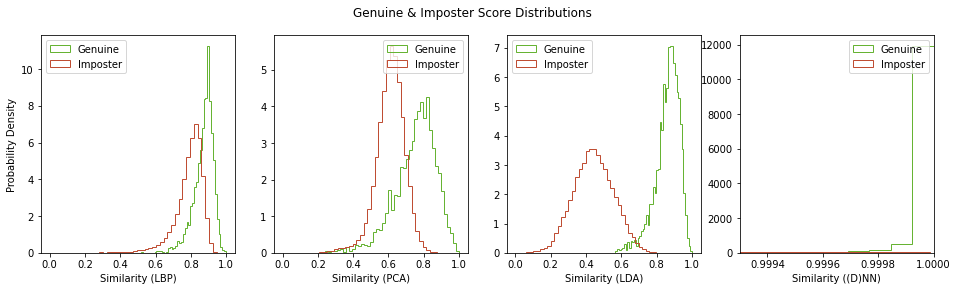

In [28]:
kwargs = dict(histtype='step', density=True, bins=45) # bins=45
figure, axes = plt.subplots(ncols=len(strategies), figsize=(16,4))
figure.suptitle('Genuine & Imposter Score Distributions')

i = 0
for strategy in strategies:
  (genuine_id, _, normalised, _) = scores_dict[strategy.name]
  scores = 1 - normalised
  axes[i].hist(scores[genuine_id > 0], color=(0.4,0.7,0.2), label='Genuine', **kwargs)
  axes[i].hist(scores[genuine_id < 1], color=(0.75,0.3,0.2), label='Imposter', **kwargs)
  if i == 0:
    axes[i].set(ylabel='Probability Density')
  axes[i].set(xlabel='Similarity (' + strategy.name + ')')
  if strategy.name == "(D)NN": # outliers ...
    axes[i].set(xlim=[sorted(scores)[len(scores)-len(scores)//10*6], 1.0])
  axes[i].legend()
  i = i + 1

plt.show()

*Two things to note :*

*(1) LDA nicely separates the distributions, more so than PCA does. This is normal. LDA is supervised and its goal is to maximise interclass variation and minimise intraclass variation. PCA just tries to capture variance but may capture irrelevant information by doing so (including lighting).*

*(2) The (D)NN has some very large outliers (when it comes to the distances for some of its imposter pairs such that it becomes difficult to display a meaningful plot. This problem of visualisation and direct comparison with the other strategies is seen in other graphs such as the F1 plots. In some cases I consider only part of its outputs to compensate for the outliers. In other cases I manually checked the F1 plot over small intervals.*

#### Task 4: Calculate Equal Error Rate

EER (LBP) =  0.24682947481862094  at threshold =  0.8436839512096802
ROC AUC (LBP) =  0.8294645582228115
EER (PCA) =  0.21211246463830033  at threshold =  0.6705720704781812
ROC AUC (PCA) =  0.8523818370531752
EER (LDA) =  0.020206685526239825  at threshold =  0.6686354849595306
ROC AUC (LDA) =  0.9984288993279737
EER ((D)NN) =  0.03138771818409253  at threshold =  0.9998339038583022
ROC AUC ((D)NN) =  0.9913389144926432


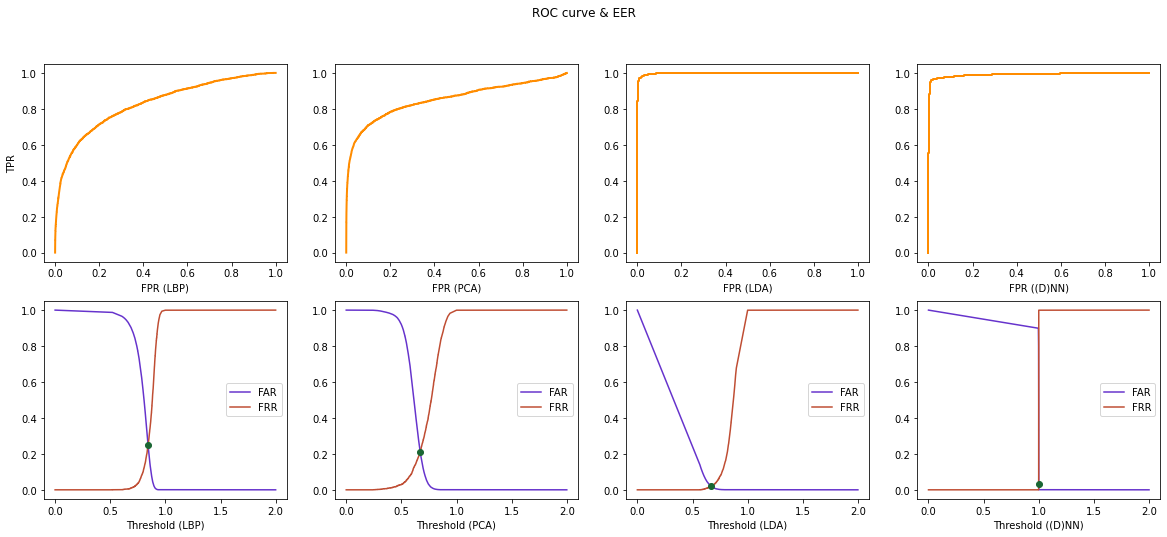

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score

figure, axes = plt.subplots(ncols=len(strategies), nrows=2, figsize=(20,8))
figure.suptitle('ROC curve & EER')

i = 0
for strategy in strategies:
  (genuine_id, _, normalised, _) = scores_dict[strategy.name]
  fpr, tpr, thresholds = roc_curve(genuine_id, 1 - normalised)
  axes[0][i].plot(fpr, tpr, color='darkorange', lw=2)
  if i == 0:
    axes[0][i].set(ylabel='TPR')
  axes[0][i].set(xlabel='FPR (' + strategy.name + ')')
  # EER
  differences = [abs((1-x)-y) for (x,y) in zip(tpr, fpr)]
  min_index = differences.index(min(differences))
  print('EER (' + strategy.name + ') = ', fpr[min_index], ' at threshold = ', thresholds[min_index])
  print('ROC AUC (' + strategy.name + ') = ', roc_auc_score(genuine_id, 1 - normalised))
  axes[1][i].scatter(thresholds[min_index], fpr[min_index], color=(0.1,0.4,0.2), zorder=3)
  axes[1][i].plot(thresholds, fpr, color=(0.4,0.2,0.8), label='FAR')
  axes[1][i].plot(thresholds, 1 - tpr, color=(0.75,0.3,0.2), label='FRR')
  axes[1][i].set(xlabel='Threshold (' + strategy.name + ')')
  axes[1][i].legend()
  i = i + 1
  
plt.show()

#### Task 5: Calculate classification scores (PR curve, AUC, Average Precision)

AUC (LBP) =  0.360758
AP (LBP) =  0.023680
AUC (PCA) =  0.549544
AP (PCA) =  0.023887
AUC (LDA) =  0.978150
AP (LDA) =  0.021711
AUC ((D)NN) =  0.953989
AP ((D)NN) =  0.021717


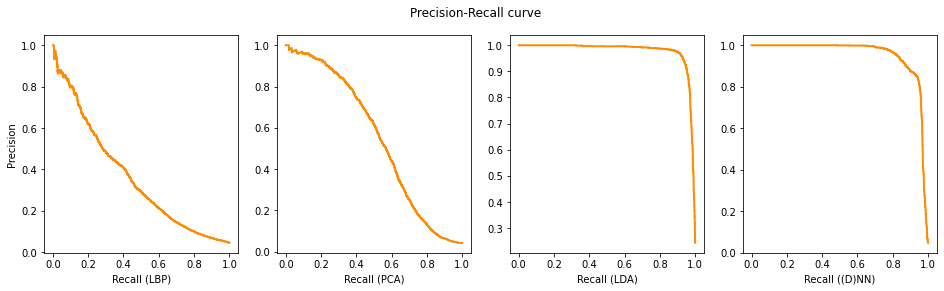

In [30]:
# Calculate PR curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

figure, axes = plt.subplots(ncols=len(strategies), figsize=(16,4))
figure.suptitle('Precision-Recall curve')

i = 0
for strategy in strategies:
  (genuine_id, _, normalised, _) = scores_dict[strategy.name]
  precision, recall, _ = precision_recall_curve(genuine_id, 1 - normalised)
  axes[i].plot(recall, precision, color='darkorange', lw=2)
  if i == 0:
    axes[i].set(ylabel='Precision')
  axes[i].set(xlabel='Recall (' + strategy.name + ')')
  i = i + 1
  print('AUC (' + strategy.name + ') = % f' % auc(recall, precision))
  print('AP (' + strategy.name + ') = % f' % average_precision_score(genuine_id, normalised))

## 6.2 Validation as identification system

#### Task 6: Generate a Cumulative Matching Curve

*This is not straightforward as the training set has multiple images per person and the so-called 'gallery' used for the CMC is supposed to have only one sample per person. So below by setting 'any=False' in the CMC function definition such a gallery is used. The influence of the choice of gallery is real but is not considered here.*

*The gallery is a subset of the target set i.e. our training set here, a set of samples with known targets. The algorithm is not tuned to it but the target set in general.*

*Right now the CMC is plotted for the similarity matrix which only considers the training set, in the evaluation phase the test set will be used instead.*

*(this is discussed in* [The FERET evaluation methodlogy for face-recognition algorithms](https://www.jordaanelectronics.com/pdfonline/face%20recognition/feret_methodology_nist_ir_6264.pdf))

*In the FVRT methodology the ROC and the CMC curves are used.*

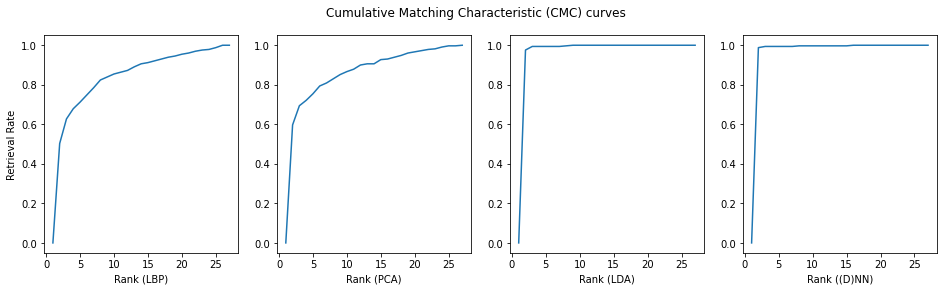

In [63]:
def CMC(matrix, probes, targets, any=False):
    gallery = [targets.index(x) for x in list(set(targets))] # for each person, index of template image
    n_ranks = len(targets) if any else len(gallery)
    cmc = [0] * n_ranks
    for (i,row) in enumerate(matrix):
      if any:
        sort = sorted(row, reverse=True)
        rank = min([sort.index(row[t]) for t in [j for j in range(len(targets)) if targets[j] == probes[i]]])
      else:
        template_scores = [row[template] for template in gallery]
        sort = sorted(template_scores, reverse=True)
        rank = sort.index(row[gallery[probes[i]]])
      if rank < len(targets):
        cmc[rank] += 1
    prev = 0
    for i in range(n_ranks):
      prev = cmc[i] + prev
      cmc[i] = prev / len(probes)
    return [0] + cmc

figure, axes = plt.subplots(ncols=len(strategies), figsize=(16,4))
figure.suptitle('Cumulative Matching Characteristic (CMC) curves')

i = 0
for strategy in strategies:
  (_, _, _, matrix) = scores_dict[strategy.name]
  probes = strategy.y_train.tolist()
  gallery = strategy.y_train.tolist()
  cmc = CMC(matrix, probes, gallery)
  axes[i].plot(list(range(1, len(cmc) + 1)), cmc)
  if i == 0:
    axes[i].set(ylabel='Retrieval Rate')
  axes[i].set(xlabel='Rank (' + strategy.name + ')')
  i = i + 1

plt.show()

*It's quite clear that LDA or the siamese network perform best. As in previous assignments ensembles are always possible, also.*

## 6.2 Validation in multi-classification setting

#### Task 7: Validate the advanced classification scenario

*Until now the binary (genuine versus imposter scores) setting was evaluated. To evaluate a multi-class classifier the macro F1 score can be used where an unweighted average is taken.*


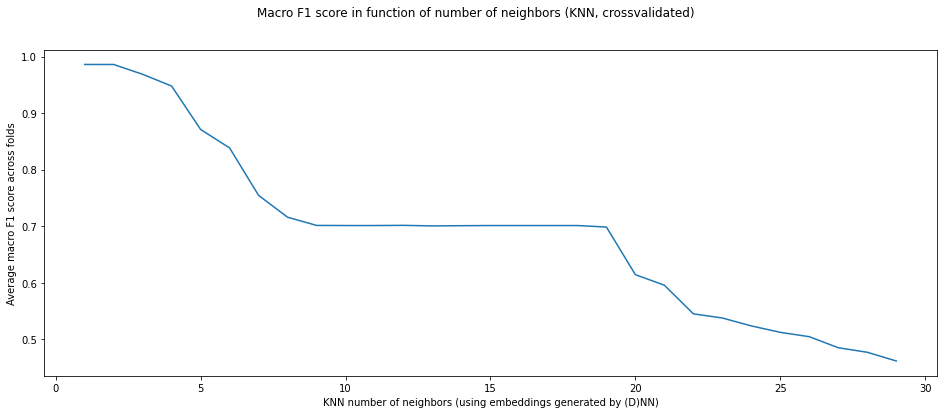

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
#from sklearn.metrics import auc
#from sklearn.model_selection import LeaveOneOut

#validator = LeaveOneOut()
#for idx_train, idx_validation in validator.split(X):

embeddings_train = strategy.describe(x_train)
nn_scores = []
test_values = list(range(1,30))
for nb_neighbors in test_values:
  knn = KNeighborsClassifier(n_neighbors=nb_neighbors, metric='euclidean')
  scores = cross_val_score(knn, embeddings_train, y_train, cv=3, scoring='f1_macro')
  nn_scores.append(sum(scores) / len(scores))

# Visualise
figure, axes = plt.subplots(figsize=(16,6))
figure.suptitle('Macro F1 score in function of number of neighbors (KNN, crossvalidated)')
plt.plot(test_values, nn_scores)
axes.set(ylabel='Average macro F1 score across folds')
axes.set(xlabel='KNN number of neighbors (using embeddings generated by ' + strategy.name + ')')
plt.show()

## 7. Task
All tasks should be accompanied by a text providing information on; the technique, the steps, and, the reasoning behind choosing the techniques.

### 7.1. Mandatory tasks

Compare the 4 feature representations (LBP, PCA, LDA, DL using Siamese Networks) using the implemented validation metrics and report on the performance below (you can for instance store your intermediary results/plots in a file and plot them below).

EER (LBP) =  0.25074342466148913  at threshold =  0.8307892914110426
ROC AUC (LBP) =  0.8245942094636668
AUC (LBP) =  0.374762
AP (LBP) =  0.025549
EER (PCA) =  0.22796431561624853  at threshold =  0.6019979364389159
ROC AUC (PCA) =  0.843000173034196
AUC (PCA) =  0.545164
AP (PCA) =  0.025494
EER (LDA) =  0.051938678291999885  at threshold =  0.6557307152455921
ROC AUC (LDA) =  0.9822649237046276
AUC (LDA) =  0.931260
AP (LDA) =  0.023399
EER ((D)NN) =  0.08516903888904928  at threshold =  0.9998641016335953
ROC AUC ((D)NN) =  0.94126264200388
AUC ((D)NN) =  0.859234
AP ((D)NN) =  0.023719


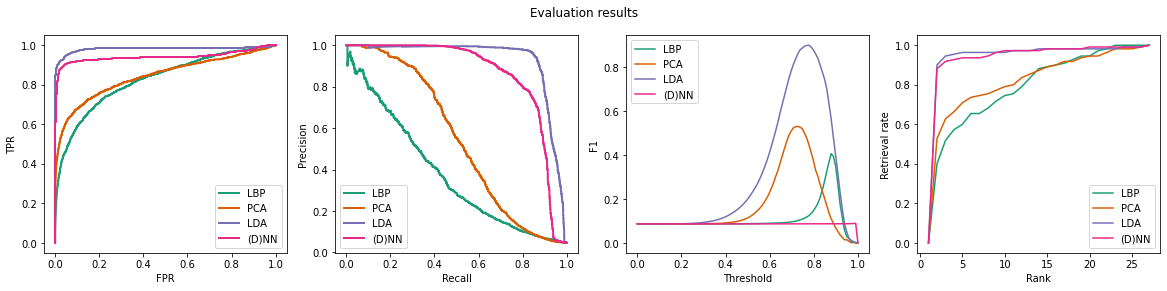

In [61]:
figure, axes = plt.subplots(ncols=4, figsize=(20,4))
figure.suptitle('Evaluation results')
axes[0].set(ylabel='TPR', xlabel='FPR')
axes[1].set(ylabel='Precision', xlabel='Recall')
axes[2].set(ylabel='F1', xlabel='Threshold')
axes[3].set(ylabel='Retrieval rate', xlabel='Rank')

color_idx = 0
colors = plt.get_cmap("Dark2").colors
for strategy in strategies:
  (genuine_id_test, _, normalised_test, matrix_test) = scores_test_dict[strategy.name]
  # ROC
  fpr, tpr, thresholds = roc_curve(genuine_id_test, 1 - normalised_test)
  axes[0].plot(fpr, tpr, color=colors[color_idx], lw=2, label=strategy.name)
  differences = [abs((1-x)-y) for (x,y) in zip(tpr, fpr)]
  min_index = differences.index(min(differences))
  print('EER (' + strategy.name + ') = ', fpr[min_index], ' at threshold = ', thresholds[min_index])
  print('ROC AUC (' + strategy.name + ') = ', roc_auc_score(genuine_id_test, 1 - normalised_test))
  # Precision-Recall
  precision, recall, _ = precision_recall_curve(genuine_id_test, 1 - normalised_test)
  axes[1].plot(recall, precision, color=colors[color_idx], lw=2, label=strategy.name)
  print('AUC (' + strategy.name + ') = % f' % auc(recall, precision))
  print('AP (' + strategy.name + ') = % f' % average_precision_score(genuine_id_test, normalised_test))
  # F1
  scores = 1 - normalised_test
  thresholds = np.linspace(0.0, 1.0, 100).tolist()
  f1_scores = [f1_score(genuine_id_test, np.where(scores >= t, 1, 0)) for t in thresholds]
  axes[2].plot(thresholds, f1_scores, color=colors[color_idx], label=strategy.name)
  # CMC
  probes = strategy.y_test.tolist()
  gallery = strategy.y_train.tolist()
  cmc = CMC(matrix_test, probes, gallery)
  axes[3].plot(list(range(1, len(cmc) + 1)), cmc, color=colors[color_idx], label=strategy.name)
  # Next color
  color_idx = color_idx + 1

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()

plt.show()

*LDA performs better than (D)NN which performs better than PCA which performs better than LBP. These results remain the same even when tuning the parameters a lot, except for the (D)NN which can outperform the LDA strategy.*  

### 7.2. Tasks of choice
<b>The student should choose a number of tasks equivalent to <u>at least 3pts</u> from the list below (pts are not related to the grades)</b>. 

1. Evaluate your system on the other two datasets (AT&T, LFW) (1pt.)
2. Implement 2 different face detectors and compare all techniques to the to the ground truth bounding boxes provided in <em>CalTechFacesDirs/ImageData.mat</em>. (1pt.)
3. Develop a new advanced classifier (beyond KNN) and compare the results with the current KNN classifier. (1pt.)
4. Experiment with the Siamese deep learning model by implementing a different loss function or a different distance calculation layer. (1pt.)
5. Pre-train your deep learning network on a different (larger) dataset and compare the results. (1pt.) 
6. Implement a different deep learning model* (2pt.)

#### Subtask 1 : evaluate your system on the other two datasets


#### Subtask 2 : implement 2 different face detectors

#### Subtask 3 : develop a new advanced classifier (beyond KNN)

In [0]:
# So do SVM here to try and get better than KNN

#### Subtask 4 : experiment with the Siamese deep learning model

#### Subtask 5 : pre-train the deep learning model on a different (larger) dataset and compare the results

#### Subtask 6 : implement a different deep learning model